# Классификаиция клиентов телеком компании

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям один из новых тариф.




**Цель исследования:** Построить модель для задачи классификации, которая выберет подходящий тариф. Построить модель с максимально большим значением `accuracy`. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до **0.75**. Проверить `accuracy` на тестовой выборке самостоятельно.
 
**Контекст исследования:**  Данные о поведении клиентов, которые уже перешли на тарифы «Смарт» или «Ультра».
 
**План исследования**:
- Изучить общую информацию о данных
- Разбить данные на выборки
- Исследовать модели
- Проверить модель на тестовой выборке
- Проверить модель на адекватность
- Сделать общие выводы по исследованию

**Описание данных:**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


___

## Откройте и изучите файл

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

In [2]:
try:
    data_users = pd.read_csv('/datasets/users_behavior.csv')
except:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
# Выводим первые 5 строчек данных
data_users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# Получаем общую информацию о данных
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
# Посмотрим на основные статистические метрики
data_users.describe().round(2)

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


---
- Данные успешно выгружены, загружены нужные библиотеки
- Пропусков в данных нет, все типы данных в столбцах тоже верные
- Предобработка не требуется
---

Пользователей с тарифом ULTRA:  985
Пользователей с тарифом SMART:  2229


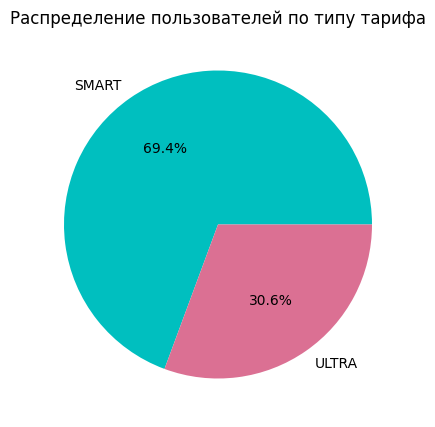

In [6]:
# Посчитаем кол-во пользователей с определенным типом тарифа
print('Пользователей с тарифом ULTRA: ', len(data_users.query('is_ultra == 1')))
print('Пользователей с тарифом SMART: ', len(data_users.query('is_ultra == 0')))

# Визуализируем процентное соотношение пользователей с подпиской и без
plt.rcParams['figure.figsize'] = (15, 5)
plt.pie(
    data_users['is_ultra'].value_counts(),
    labels=['SMART', 'ULTRA'],
    autopct='%1.1f%%',
    colors=['c', 'palevioletred']
)
plt.title('Распределение пользователей по типу тарифа')
plt.grid()
plt.show()

In [7]:
# Проверим корреляции между переменными для исключения возникновения мультиколлинеарности
data_users.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


---
Наблюдаем сильную корреляцию между количеством звонков и суммарной длительностью звонков. Логично, ведь это неотъемлемо зависимые друг от друга переменные. Однако что касается распределения по тарифам - особо сильной зависимости с другими переменными - нет.

---

## Разбиваем данные на выборки

---
- Поскольку мы разбиваем исходные данные на **обучающую, валидационную и тестовую выборки**, предлагаю выполнить разбивку в соотношении 3:1:1 соответственно
- Целевой столбец - категориальные величины тарифов - `is_ultra`

*P.S. Гуглил некоторую информацию о разбивке данных и наткнулся на интересный параметр `stratify` (судя по всему, используется для справедливости баланса в поделенных выборках) - решил применить*

---

In [8]:
# Обозначим features и target 
features = data_users.drop('is_ultra', axis=1)
target = data_users['is_ultra']

# Разобьем все данные на обучающую выборку и (валидационную + тестовую) -> для обучающей оставим 60% 
features_train, features_split, target_train, target_split = train_test_split(features, target,
                                                                              test_size=0.4,
                                                                              random_state=12345,
                                                                              stratify=target)
# Разобьем оставшиеся выборки пополам -> на валидационную (20%) и тестовую (20%)
features_test, features_valid, target_test, target_valid = train_test_split(features_split, target_split,
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_split)


In [9]:
# Проверим размер выборок
display(features_train.shape)
display(features_test.shape)
display(features_valid.shape)
display(target_train.shape)
display(target_test.shape)
display(target_valid.shape)

(1928, 4)

(643, 4)

(643, 4)

(1928,)

(643,)

(643,)

## Исследование моделей

In [10]:
# Создадим словарь, чтобы записывать в него лучшие модели и их точности на валидационной выборке.
dict_model = {}

---
Не уверен, стоит ли сохранять лучшие модели через библиотеку `joblib`, но захотелось поэкспериментировать :)

---

### Дерево решений 

In [11]:
# Определим пустые параметры для дальнейшего заполнения их лучшей моделью и её результатом точности
best_model_tree = None
best_result_tree = 0
tree_acc_train = []
tree_acc_valid = []

# Пройдемся по циклу глубины дерева для определения лучшей модели
for depth in tqdm(range(1, 50)):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    tree_acc_train.append(model_tree.score(features_train, target_train))
    predictions = model_tree.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    tree_acc_valid.append(result)
    if result > best_result_tree:
        best_result_tree = result
        best_model_tree = model_tree
        joblib.dump(model_tree, 'best_model_tree.joblib')
dict_model[best_model_tree] = best_result_tree

print("Лучшая точность:", best_result_tree)

100%|██████████| 49/49 [00:00<00:00, 152.72it/s]

Лучшая точность: 0.8118195956454122


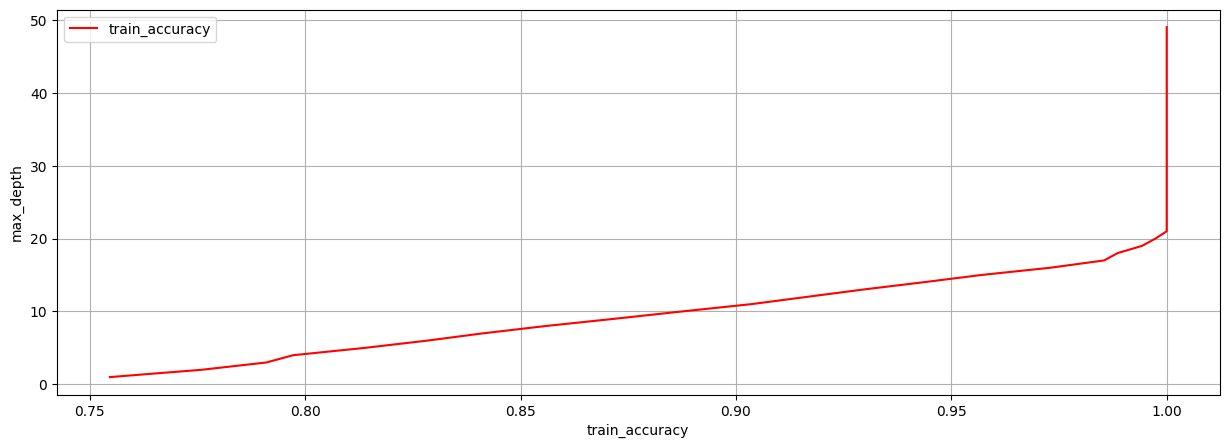

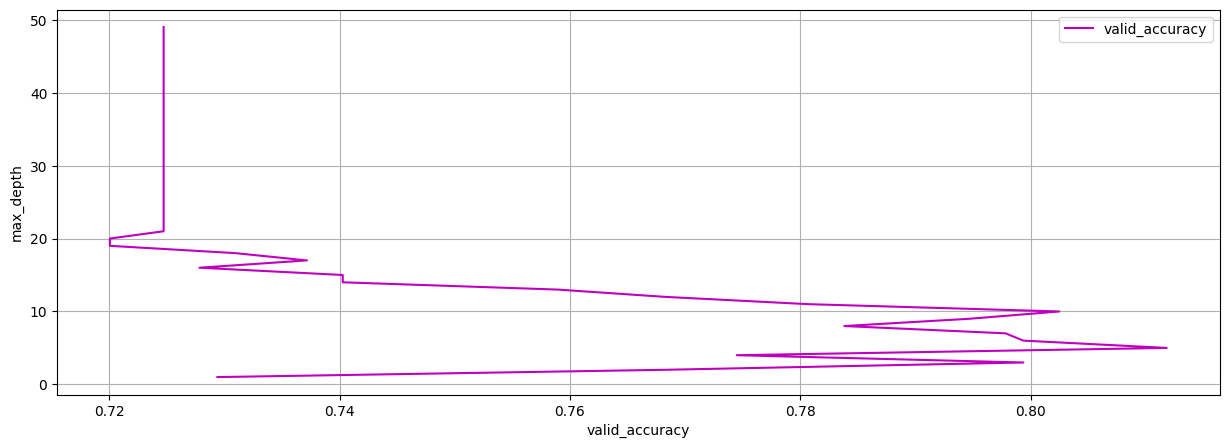

In [12]:
# Визуализируем изменение точности на обучающей и валидационной выборках при изменении max_depth
tree_plot = pd.DataFrame({'valid_accuracy': tree_acc_valid, 'train_accuracy': tree_acc_train, 'depth': range(1, 50)})

tree_plot.plot(x='train_accuracy', y='depth', color='r')
plt.rcParams['figure.figsize'] = (15, 5)
plt.ylabel('max_depth')
plt.legend(['train_accuracy'])
plt.grid()
plt.show()
tree_plot.plot(x='valid_accuracy', y='depth', color='m')
plt.rcParams['figure.figsize'] = (15, 5)
plt.ylabel('max_depth')
plt.legend(['valid_accuracy'])
plt.grid()
plt.show()

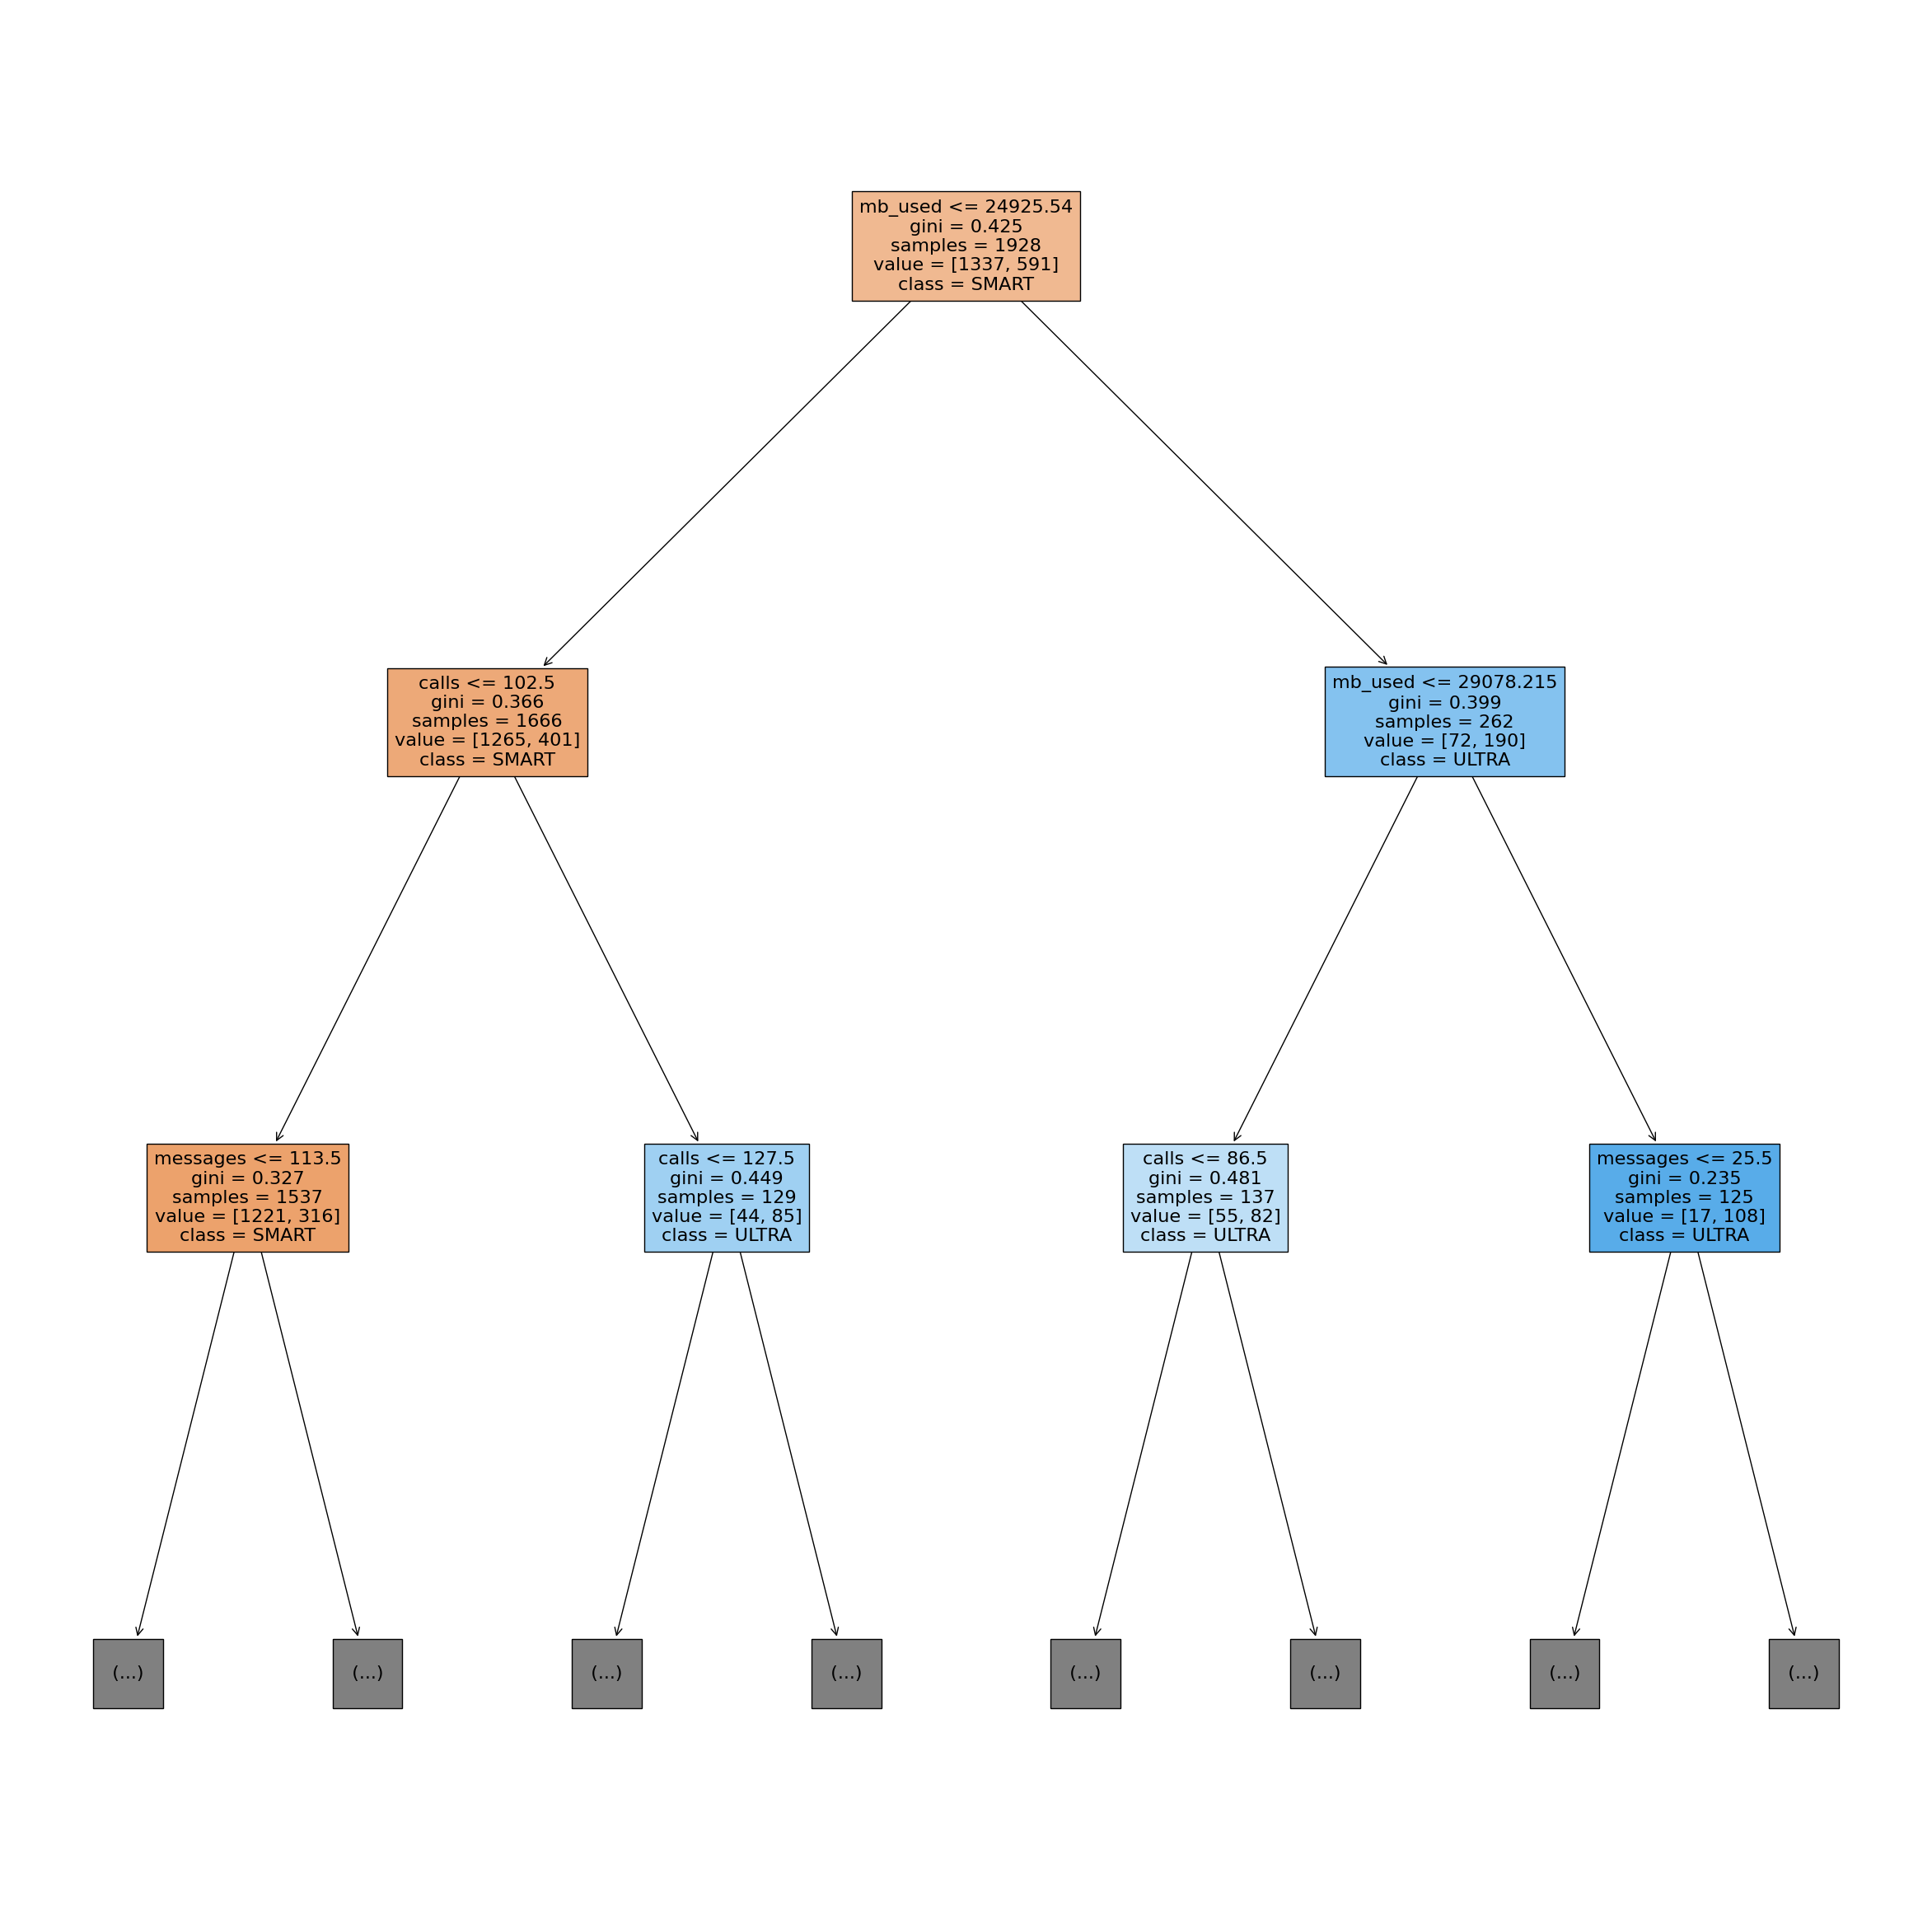

In [13]:
# Визуализируем само дерево решений для того, чтобы понимать какие сплиты выполняются
plt.figure(figsize=(30, 30));
_ = tree.plot_tree(best_model_tree,
                   feature_names=features.columns,
                   max_depth=2,
                   class_names=['SMART', 'ULTRA'],
                   filled=True)
plt.show()

---
- По результатам перебора гиперпараметров, после `max_depth == 20` -> точность на обучающей выборке не увеличивается
- На валидационной выборке модель начинает переобучаться после параметра `max_depth == 10` и точность **снижается**

---

### Случайный лес

In [14]:
# Определим пустые параметры для дальнейшего заполнения их лучшей моделью и её результатом точности
best_model_forest = None
best_result_forest = 0
forest_acc_train = []
forest_acc_valid = []

# Пройдемся по циклам количества деревьев и глубины дерева для определения лучшей модели
for trees in tqdm(range(3, 8)):
    for depth in range(2, 10):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=trees, max_depth=depth)
        model_forest.fit(features_train, target_train)
        forest_acc_train.append(model_forest.score(features_train, target_train))
        predictions = model_forest.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        forest_acc_valid.append(result)
        if result > best_result_tree:
            best_result_forest = result
            best_model_forest = model_forest
            joblib.dump(model_forest, 'best_model_forest.joblib')
dict_model[best_model_forest] = best_result_forest

print("Лучшая точность:", best_result_forest)

100%|██████████| 5/5 [00:00<00:00, 14.85it/s]

Лучшая точность: 0.8149300155520995


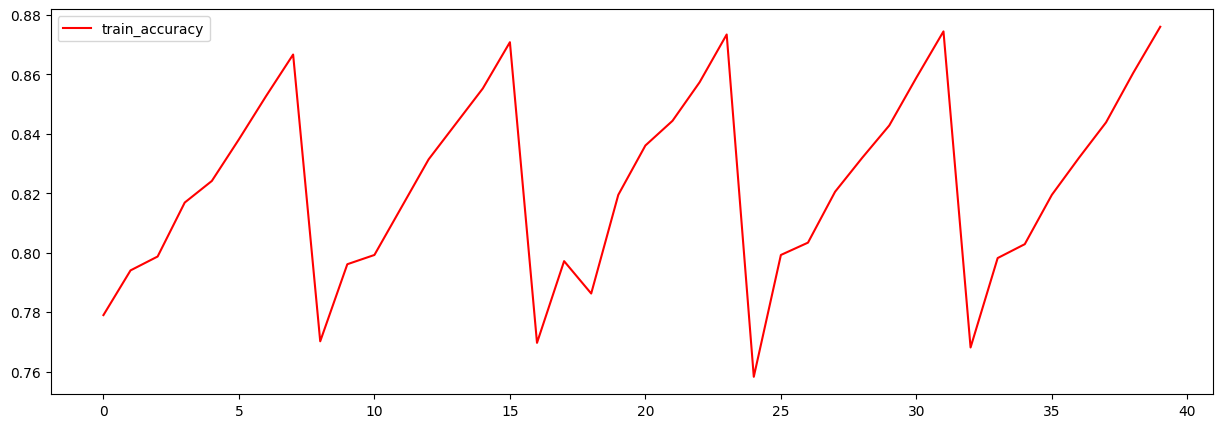

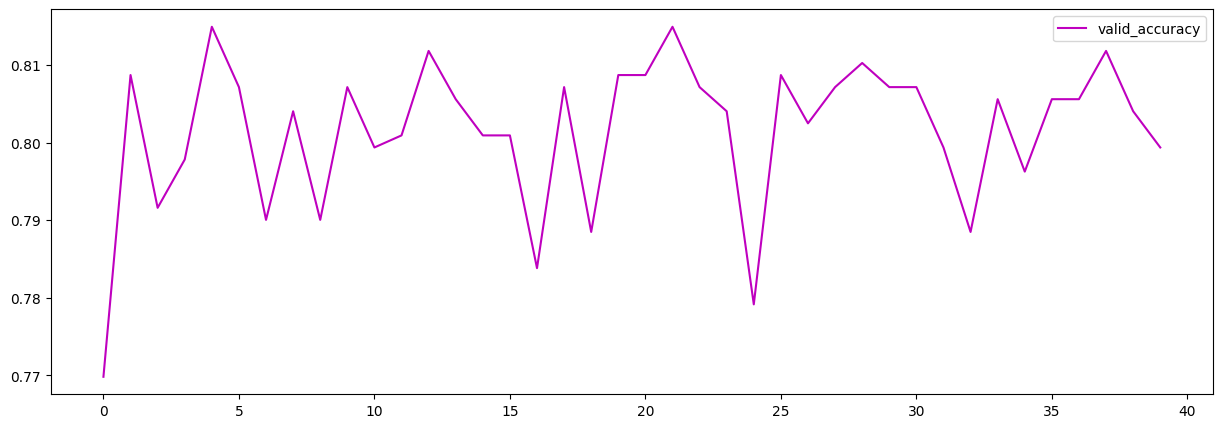

In [15]:
# Визуализируем изменение точности на обучающей и валидационной выборках при изменении max_depth
forest_plot = pd.DataFrame({'valid_accuracy': forest_acc_valid, 'train_accuracy': forest_acc_train})

plt.plot(forest_plot['train_accuracy'], color='r')
plt.legend(['train_accuracy'])
plt.show()
plt.plot(forest_plot['valid_accuracy'], color='m')
plt.legend(['valid_accuracy'])
plt.show()

---
По результатам перебора гиперпараметров, после `max_depth == 10`  и `n_estimators == 8` -> точность не увеличивается

---

### Логистическая регрессия

In [16]:
best_model_logic = None
best_result_logic = 0

model_logic = LogisticRegression(random_state=12345, max_iter=100)
model_logic.fit(features_train, target_train)
result = model_logic.score(features_valid, target_valid)
joblib.dump(model_logic, 'best_model_logic.joblib')
dict_model[model_logic] = result

print("Точность модели:", result)

Точность модели: 0.7465007776049767


---
По результатам перебора гиперпараметров, после `max_iter = 100` -> точность не увеличивается

---

### Вывод по результатам исследования различных моделей

In [17]:
dict_model

{DecisionTreeClassifier(max_depth=5, random_state=12345): 0.8118195956454122,
 RandomForestClassifier(max_depth=7, n_estimators=5, random_state=12345): 0.8149300155520995,
 LogisticRegression(random_state=12345): 0.7465007776049767}

---
1. **RandomForestClassifier** *(случайный лес)* - фаворит среди моделей. Модель показала лучшую точность среди других - **0.81493** при показателях `max_depth` = 7  и  `n_estimators` = 5 
2. На втором месте - **DecisionTreeClassifier** *(дерево решений)*. Она выдала точность ~ 0.8118 при `max_depth` = 5
3. Последняя модель в рейтинге - **LogisticRegression** *(логистическая регрессия)* с точностью ~ 0.7465

---

## Проверка модели на тестовой выборке

---
- Для начала дообучим нашу лучшую модель (RF) с лучшими значениями гиперпараметров на тренировочной + валидационной выборке. 

---

In [18]:
# Объединим тренировочную + валидационную выборку
features_new_train = pd.concat([features_train, features_valid])
target_new_train = pd.concat([target_train, target_valid])

In [19]:
# Обучаем лучшую модель на новой объединенной выборке и проверяем на тестовой выборке 
new_forest_model = RandomForestClassifier(max_depth=7, n_estimators=5, random_state=1234)
new_forest_model.fit(features_new_train, target_new_train)
new_forest_predictions = new_forest_model.predict(features_test)
new_result = accuracy_score(target_test, new_forest_predictions)

# Выведем старый и новый результат точности
print(f'Точность старой модели на тестовой выборке: {best_model_forest.score(features_test, target_test)}')
print(f'Точность новой дообученной модели на тестовой выборке: {new_result}')

Точность старой модели на тестовой выборке: 0.7807153965785381
Точность новой дообученной модели на тестовой выборке: 0.8102643856920684


---
- Дообученная модель RF показала более точный результат метрики качества после проверки на тестовой выборке, чем старая
- Окончательная точность выбранной модели на тестовой выборке: `0.8102643856920684` 

---

## Проверка модели на адекватность

In [20]:
# Обучим "глупую модель" и сравним её точность с точностью предсказания нашей лучшей модели
dummy_model = DummyClassifier()
dummy_model.fit(features_train, target_train)
print('Точность "простой" модели:', dummy_model.score(features_test, target_test))
print('Точность лучшей модели:', new_result)


Точность "простой" модели: 0.6936236391912908
Точность лучшей модели: 0.8102643856920684


---
Хорошо, что точность "простой" модели **ниже** нашей - это указывает на адекватность лучшей модели. 

---

## Общий вывод

---
**По результатам исследования, лучшей моделью для задачи классификации, которая выбирает подходящий тариф, оказалась модель `RandomForestClassifier` с гиперпараметрами `max_depth = 7`и `n_estimators = 5`. Ее точность предсказания на тестовой выборке составила ` 0.8102643856920684`**. 
Обучили модели "Дерево решений", "Случайный лес" и "Логистическая регрессия", применяя различные гиперпараметры для каждой.

---

*Исследование было разделено на несколько этапов:*



**1. Изучение общей информации о данных:**
- Загрузили необходимые для работы библиотеки
- Успешно выгрузили и изучили предоставленные данные о поведении клиентов, которые уже перешли на тарифы «Смарт» или «Ультра».
- Данные оказались готовыми для работы - не было выявлено пропусков или расхождений в типах данных

**2. Разбивка данных на выборки:**
- Разбили данные на три выборки *(в соотношении 3:1:1)*: на обучающую, валидационную и тестовую
- Применили новоизученный параметр `stratify`

**3. Исследование моделей:**
- Провели исследование трёх изученных ранее моделей на валидационной выборке
- `RandomForestClassifier` (случайный лес) - оказалась фаворитом среди моделей. Модель показала лучшую точность среди других - `0.81493` при показателях max_depth = 7 и n_estimators = 5
- На втором месте - `DecisionTreeClassifier` (дерево решений). Она выдала точность `~ 0.8118` при max_depth = 5
- Последняя модель в "рейтинге" - `LogisticRegression` (логистическая регрессия) с точностью `~ 0.7465`

**4. Проверка моделей на тестовой выборке:**
- Объединили тренировочную и валидационную выборку в новую обучающую, на которой *дообучили* лучшую модель с лучшими гиперпараметрами
- Дообученная модель RF показала более точный результат метрики качества после проверки на тестовой выборке, чем старая
- Окончательная точность выбранной модели на тестовой выборке: `0.8102643856920684`


**5. Проверка модели на адекватность:**
- Обучили "глупую" модель, которая всегда предсказывает один тариф
- Сверили точности предсказаний "глупой" модели и нашей лучшей модели на тестовых выборках -> лучшая модель показала **более точный уровень предсказаний**
- "Лучшая" модель -> адекватная